In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

In [2]:
# from tf.keras.models import Sequential  # This does not work!
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

# Inspecting and Preparing Data

Load in the data and take a glance at what is inside:

In [3]:
pjme = pd.read_csv('PJME_hourly.csv')

In [4]:
# look at data
display(pjme.head())

#look at data types to see if we need to transform
display(pjme.dtypes)

# look at basic statistics of data
display(pjme.describe())

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


Datetime     object
PJME_MW     float64
dtype: object

,PJME_MW
count,145366.000000
mean,32080.222831
std,6464.012166
min,14544.000000
25%,27573.000000
50%,31421.000000
75%,35650.000000
max,62009.000000


We will have to transform the Datetime column to datetime objects. Luckily, they are using a standard format.

In [5]:
# Transform Datetime column
pjme.Datetime = pd.to_datetime(pjme.Datetime)

In [6]:
# Use Datetime column as index
pjme = pjme.set_index('Datetime')

/Users/Paul/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


<function matplotlib.pyplot.show(*args, **kw)>

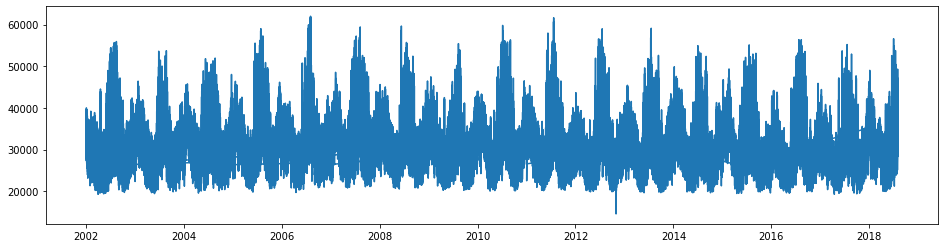

In [7]:
# Plot data
plt.figure(figsize = (16,4))
plt.plot(pjme.PJME_MW)
plt.show

At first glance, our data looks relatively stationary, meaning that it has:
 - constant mean
 - constant variance
 - autocovariance independent of time
 
 This is a basic assumption of most time-series models. We can use a Rickey-Fuller test to ensure confidence that we are working with stationary data. The following block of code for conducting the test was found through the PyData LA 2018 presentation on time series analysis.

In [11]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(df, ts):
    """
    Test stationarity using moving average statistics and Dickey-Fuller test
    Source: https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
    """
    
    # Determing rolling statistics
    rolmean = df[ts].rolling(window = 12, center = False).mean()
    rolstd = df[ts].rolling(window = 12, center = False).std()
    
    # Plot rolling statistics:
    orig = plt.plot(df[ts], 
                    color = 'blue', 
                    label = 'Original')
    mean = plt.plot(rolmean, 
                    color = 'red', 
                    label = 'Rolling Mean')
    std = plt.plot(rolstd, 
                   color = 'black', 
                   label = 'Rolling Std')
    plt.legend(loc = 'best')
    plt.title('Rolling Mean & Standard Deviation for %s' %(ts))
    plt.xticks(rotation = 45)
    plt.show(block = False)
    plt.close()
    
    # Perform Dickey-Fuller test:
    # Null Hypothesis (H_0): time series is not stationary
    # Alternate Hypothesis (H_1): time series is stationary
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(df[ts], 
                      autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], 
                         index = ['Test Statistic',
                                  'p-value',
                                  '# Lags Used',
                                  'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

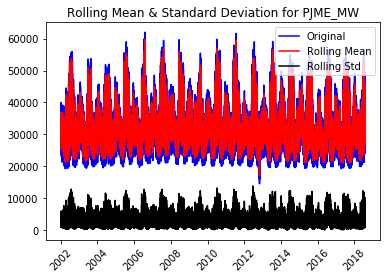

Results of Dickey-Fuller Test:
Test Statistic                -1.882891e+01
p-value                        2.022125e-30
# Lags Used                    7.400000e+01
Number of Observations Used    1.452910e+05
Critical Value (1%)           -3.430395e+00
Critical Value (5%)           -2.861560e+00
Critical Value (10%)          -2.566781e+00
dtype: float64


In [12]:
test_stationarity(df = pjme, ts = 'PJME_MW')

The Dickey-Fuller test p-value is much smaller than 0.05, so we successfully reject the null hypothesis that there is a unit root (that the time series is not stationary). This means that our data IS stationary.

Since our data is stationary, we will not need to transform it before continuing to ARIMA modeling.

### Choosing ARIMA parameters:

ARIMA uses 3 parameters: p, d, and q.

#### Determining d:

We may want to difference our data (take the relative difference of values instead of the values themselves) to better help our model. Typically, we will choose the degree of differencing that reduces the standard deviation the most. This order of differencing corresponds with the d parameter in the ARIMA model: 

In [17]:
def plot_transformed(original, transformed):
    '''
    Plots two Series on the same figure
    original: Pandas Series object
    transformed: transformation of original
    '''

    fig, ax = plt.subplots(1,1, figsize = (10,4))
    
    ax.plot(original, color = 'gray', label='original')
    ax.plot(transformed, label='transformed')
    
    #add legend
    ax.legend()
    
    plt.show()

differencing of order 1


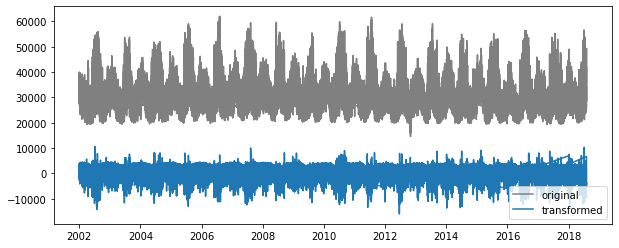

standard deviation: 1576.4275538503607


differencing of order 2


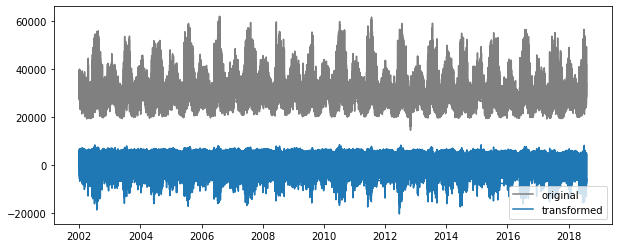

standard deviation: 2915.4986060947676


differencing of order 3


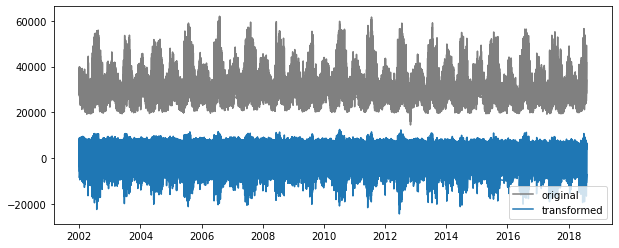

standard deviation: 4106.234563457409


In [21]:
# differencing with a lag of 1:
diff_1 = pjme['PJME_MW'].diff().rename('diff_1')

# differencing with a lag of 2:
diff_2 = pjme['PJME_MW'].diff(2).rename('diff_2')

# differencing with a lag of 2:
diff_3 = pjme['PJME_MW'].diff(3).rename('diff_3')

#plotting:
print('differencing of order 1')
plot_transformed(pjme.PJME_MW, diff_1)
print(f'standard deviation: {diff_1.std()}')

print('\n\ndifferencing of order 2')
plot_transformed(pjme.PJME_MW, diff_2)
print(f'standard deviation: {diff_2.std()}')

print('\n\ndifferencing of order 3')
plot_transformed(pjme.PJME_MW, diff_3)
print(f'standard deviation: {diff_3.std()}')

Differencing of order 1 renders data with the lowest standard deviation, so we will try a d value of 1 at first.

#### Determining p and q:

p is the number of terms to use for the auto-regression portion of the ARIMA model (how many previous terms to include as features in our regressor to determine the next value). We can use a partial auto-correlation plot to give us an idea. This plots the partial correlation between the values relative to the level of lag. partial auto-correlation is analagous to covariance: it is the correlation that is shared solely at that lag value and is not explained by any other shared correlation with other lag values.

q is the number of terms to use for the moving average portion. This can be determined by inspecting the simple auto-correlation plot (rather than partial correlation).

In [48]:
def plot_autocorrelation(sequence):
    '''
    Plots autocorrelation and partial autocorrelation of a sequence of data
    sequence: Pandas Series object
    '''

    from statsmodels.tsa.stattools import acf, pacf

    lag_acf = acf(sequence, nlags = 20, fft = True)
    lag_pacf = pacf(sequence, nlags = 20)

    fig, axes = plt.subplots(1,2, figsize = (10,4))

    # plot ACF
    axes[0].plot(lag_acf)
    axes[0].axhline(y = 0, color = 'gray')
    axes[0].axhline(y = -1.96/(len(sequence)**0.5),
                    color = 'gray',
                    linestyle = '--')
    axes[0].axhline(y = 1.96/(len(sequence)**0.5),
                    color = 'gray',
                    linestyle = '--')
    axes[0].set_title(f'Autocorrelation of {sequence.name}')

    # plot PACF
    axes[1].plot(lag_pacf)
    axes[1].axhline(y = 0, color = 'gray')
    axes[1].axhline(y = -1.96/(len(sequence)**0.5),
                    color = 'gray',
                    linestyle = '--')
    axes[1].axhline(y = 1.96/(len(sequence)**0.5),
                    color = 'gray',
                    linestyle = '--')
    axes[1].set_title(f'Partial autocorrelation of {sequence.name}')
    
    plt.show()
    

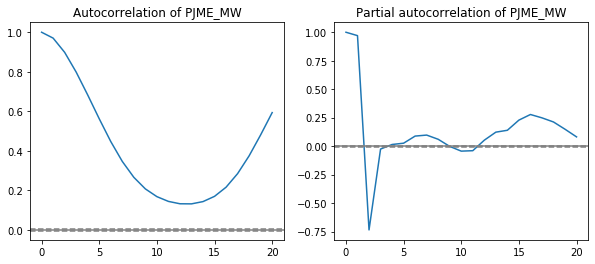

In [49]:
# plotting autocorrelation with no differencing
plot_autocorrelation(pjme.PJME_MW)

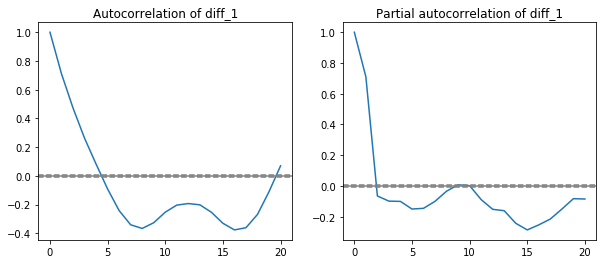

In [50]:
# plotting autocorrelation for differencing of 1
plot_autocorrelation(diff_1[1:])

The autocorrelation plots again show that differencing of order 1 is probably the best choice. We choose q where the autocorrelation plot first crosses the significance margin, and we choose p using the same method with the partial autocorrelation plot. This renders values of around 5 and 2, respectively. This, we will continue with:
- p = 2
- d = 1
- q = 5

In [77]:
from statsmodels.tsa.arima_model import ARIMA
from math import floor
from sklearn.metrics import mean_squared_error

def run_ARIMA(sequence, params, training_proportion=0.8):
    '''
    Creates an ARIMA model fitted on the given sequence, tests on unseen data, and plots results.
    sequence: Pandas Series object
    params: three-element tuple containing parameter values for p,d,and q, respectively
    '''
    train_len = floor(training_proportion*len(sequence))
    train = sequence[0:train_len]
    test = sequence[train_len:-1]
    
    arima = ARIMA(train, order=params)
    arima_fitted = arima.fit(disp=0)
    # print(arima_fitted.summary())
    
    # predicting
    predictions = arima_fitted.forecast(steps = len(test))[0]
    
    # error
    print('test type:', type(test), 'len:', len(test), 'sample:', test[0:3], '\n')
    print('pred type:', type(predictions), 'len:', len(predictions), 'sample:', predictions[0:3], '\n')
    rmse = mean_squared_error(test, predictions)**0.5
    
    # plot results
    fig, ax = plt.subplots(1,1, figsize = (10,4))
    ax.plot(np.array(sequence[train_len:-1]), color='gray', label='true')
    ax.plot(predictions, label='predicted')
    ax.set_title(f'ARIMA with (p, d, q) = {params}')   
    print(f'rmse: {rmse}')
    plt.show()
    
    return arima_fitted

/Users/Paul/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/Paul/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


test type: <class 'pandas.core.series.Series'> len: 399 sample: Datetime
2002-10-26 18:00:00    26873.0
2002-10-26 19:00:00    28663.0
2002-10-26 20:00:00    28964.0
Name: PJME_MW, dtype: float64 

pred type: <class 'numpy.ndarray'> len: 399 sample: [26423.07129242 26590.35469741 26856.95928926] 

rmse: 4214.457938566614


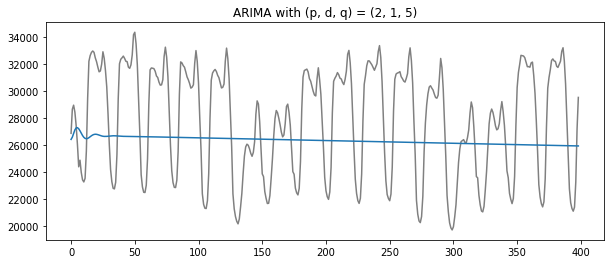

/Users/Paul/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/Paul/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


test type: <class 'pandas.core.series.Series'> len: 399 sample: Datetime
2002-10-26 18:00:00    26873.0
2002-10-26 19:00:00    28663.0
2002-10-26 20:00:00    28964.0
Name: PJME_MW, dtype: float64 

pred type: <class 'numpy.ndarray'> len: 399 sample: [26436.83612245 26452.92879385 26478.71200579] 

rmse: 3982.009123739146


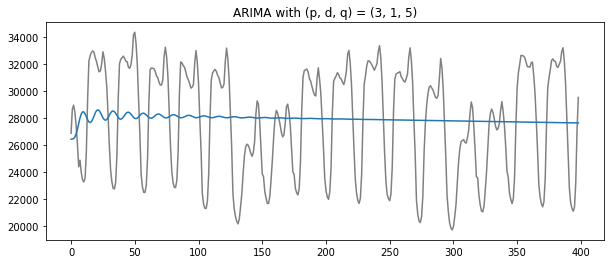

/Users/Paul/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/Paul/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


test type: <class 'pandas.core.series.Series'> len: 399 sample: Datetime
2002-10-26 18:00:00    26873.0
2002-10-26 19:00:00    28663.0
2002-10-26 20:00:00    28964.0
Name: PJME_MW, dtype: float64 

pred type: <class 'numpy.ndarray'> len: 399 sample: [26801.42513002 27318.14461932 27685.71477732] 

rmse: 4012.1897244404795


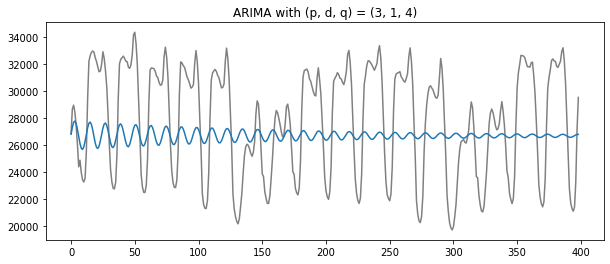

In [81]:
run_ARIMA(pjme.PJME_MW[0:2000], (2,1,5))
run_ARIMA(pjme.PJME_MW[0:2000], (3,1,5))
run_ARIMA(pjme.PJME_MW[0:2000], (3,1,4))

It apprears our model is at least a decent fit for our data. We can compare it with a more sophisticated method, such as LSTM:

## Univariate LSTM:

Running an LSTM model can be done through Keras, a deep learning library within Tensorflow. We will first run a univariate LSTM model, and then move to a multivariate.

In [8]:
from numpy import array

def get_inputs(sequence, steps):
    '''
    Create inputs for training LSTM with time series data X and y. 
    sequence: array-like time-series data
    steps: number of previous data points to take into account
    X will be a array of sequences within the column of length 'steps'.
    y will be a array of the values immediately following those sequences.
    '''
    
    # initialize X and y
    X, y = list(), list()
    
    # create X and y.
    for i in range(len(sequence)):
        
        upper = i+steps
        
        if upper+1 > len(sequence):
            break
            
        X.append(sequence[i:upper])
        y.append(sequence[upper])
    
    return array(X), array(y)

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_squared_error
from math import floor

def run_univariate(sequence, n_steps, train_proportion=0.8, n_features=1, LSTM_units=50, 
                   activation='relu', optomizer='adam', loss='mse', epochs=40, verbose=0):

    # create input data
    train_len = floor(train_proportion*len(sequence))
    X, y = get_inputs(list(pjme.PJME_MW[0:train_len]), n_steps)
    X = X.reshape(X.shape[0], X.shape[1], 1) # must be 3-dimensional

    #initialize model
    univariate = Sequential()
    univariate.add(LSTM(LSTM_units, activation=activation, input_shape=(n_steps,n_features)))
    univariate.add(Dense(1))
    univariate.compile(optimizer=optomizer, loss=loss)
    
    #fit model
    univariate.fit(X, y, epochs=epochs, verbose=verbose)

    # test model
    X_test, y_test = get_inputs(list(pjme.PJME_MW[train_len:len(sequence)]), n_steps)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], n_features) # must be 3-dimensional
    y_predict = univariate.predict(X_test, verbose=0)
    
    # print error
    print(f'RMSE: {mean_squared_error(y_test, y_predict)**0.5}')
          
    # plot model
    fig, ax = plt.subplots(1,1, figsize = (10,4))
    ax.plot(y_test, color='gray', label='true')
    ax.plot(y_predict, color='blue', label='predicted')
    ax.set_title(f'Model using step size {n_steps} through {epochs} epochs:')
    ax.legend()
    plt.show()
    
    return univariate

RMSE: 3609.3549465211504


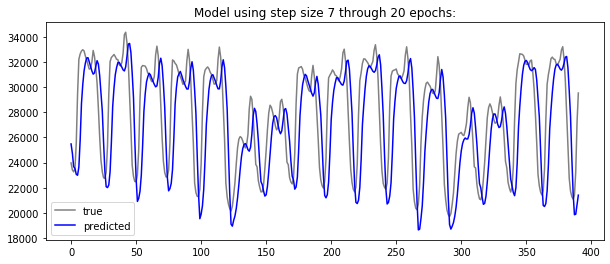

In [145]:
run_univariate(list(pjme.PJME_MW[0:2000]), n_steps = 7, epochs = 20)

Even with a rudementary LSTM model, we are already performing with much more nuance than an ARIMA model. Let's keep improving.

## Stacked univariate LSTM:

We can add additional neural layers to make our LSTM model truly a 'deep' learning model.
This will still function similarly to the previous model we constructed, but will have one additional intermediary later beterrn the input and the dense layer.

In [9]:
def run_univariate_stacked(sequence, n_steps, train_proportion=0.8, n_features=1, LSTM_units=50, 
                   activation='relu', optomizer='adam', loss='mse', epochs=40, verbose=0):

    # create input data
    train_len = floor(train_proportion*len(sequence))
    X, y = get_inputs(list(pjme.PJME_MW[0:train_len]), n_steps)
    X = X.reshape(X.shape[0], X.shape[1], 1) # must be 3-dimensional

    #initialize model
    univariate = Sequential()
    univariate.add(LSTM(LSTM_units, activation=activation, 
                        return_sequences=1, input_shape=(n_steps,n_features)))
    univariate.add(LSTM(LSTM_units, activation=activation))
    univariate.add(Dense(1))
    univariate.compile(optimizer=optomizer, loss=loss)
    
    #fit model
    univariate.fit(X, y, epochs=epochs, verbose=verbose)

    # test model
    X_test, y_test = get_inputs(list(pjme.PJME_MW[train_len:len(sequence)]), n_steps)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], n_features) # must be 3-dimensional
    y_predict = univariate.predict(X_test, verbose=0)
    
    # print error
    print(f'RMSE: {mean_squared_error(y_test, y_predict)**0.5}')
          
    # plot model
    fig, ax = plt.subplots(1,1, figsize = (10,4))
    ax.plot(y_test, color='gray', label='true')
    ax.plot(y_predict, color='blue', label='predicted')
    ax.set_title(f'Model using step size {n_steps} through {epochs} epochs:')
    ax.legend()
    plt.show()
    
    return univariate

RMSE: 2985.6494501821385


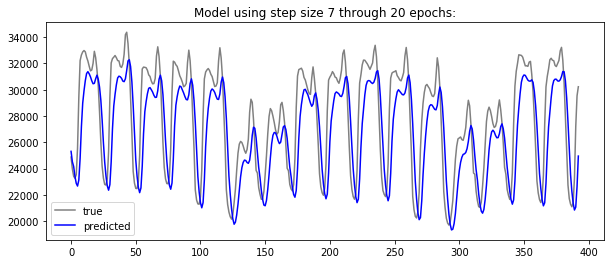

In [159]:
run_univariate_stacked(list(pjme.PJME_MW[0:2000]), n_steps = 7, epochs = 20)

## Multivariate LSTM:

Our model can be improved if we include more data. Some of this can be created from the information that we already have, such as the hour of the day, dat of the week, etc. This might give our model more context. For example, it might seem intuitive to us that summer months will lead to higher energy use due to air conditioning, but our model won't be able to take that into account unless we give it seasonal data.

To implement this data, we will have to build a different LSTM model that is capable of using multivariate data. 

In [11]:
pjme['hour'] = pjme.index.hour
pjme['dayofweek'] = pjme.index.dayofweek
pjme['dayofmonth'] = pjme.index.day
pjme['dayofyear'] = pjme.index.dayofyear
pjme['month'] = pjme.index.month
pjme['year'] = pjme.index.year
pjme['weekofyear'] = pjme.index.weekofyear

In [12]:
pjme.head()

,PJME_MW,hour,dayofweek,dayofmonth,dayofyear,month,year,weekofyear
Datetime,,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,31,365,12,2002,1
2002-12-31 02:00:00,25147.0,2,1,31,365,12,2002,1
2002-12-31 03:00:00,24574.0,3,1,31,365,12,2002,1
2002-12-31 04:00:00,24393.0,4,1,31,365,12,2002,1
2002-12-31 05:00:00,24860.0,5,1,31,365,12,2002,1


In [13]:
def get_multiple_inputs(data, target, n_steps):
    '''
    Creates LSTM inputs for time series forecasting given an ndarray 
    representing columns of variables and a target column
    
    inputs:
        data: ndarray object
        target: column index of target variable
        n_steps: number of observations to take into account for 
            each prediction
    
    outputs:
        X: 3-dimensional ndarray representing the input variables
        y: 2-dimansional ndarray representing the output variable
    
    '''
    
    len_data = data.shape[0]
    
    #initialize X and y
    X, y = list(),list()
    
    for i in range(len_data):
        
        upper = n_steps+i
        
        # make sure we don't over-index
        if upper+1 > len_data:
            break
        
        # add to X and y
        X.append(data[i:upper,:])
        y.append(data[:,target][upper])
        
    return array(X), array(y)      

In [14]:
def run_multivariate(data, target, n_steps, train_proportion=0.8, LSTM_units=50, 
                   activation='relu', optomizer='adam', loss='mse', epochs=40, verbose=0):

    # create input data
    train_len = floor(train_proportion*data.shape[0])
    X, y = get_multiple_inputs(data[0:train_len,:], target, n_steps)
    n_features = X.shape[2]

    #initialize model
    model = Sequential()
    model.add(LSTM(LSTM_units, activation=activation, input_shape=(n_steps,n_features)))
    model.add(Dense(1))
    model.compile(optimizer=optomizer, loss=loss)
    
    #fit model
    model.fit(X, y, epochs=epochs, verbose=verbose)

    # test model
    X_test, y_test = get_multiple_inputs(data[train_len:data.shape[0],:], target, n_steps)
    y_predict = model.predict(X_test, verbose=0)
    
    # print error
    print(f'RMSE: {mean_squared_error(y_test, y_predict)**0.5}')
          
    # plot model
    fig, ax = plt.subplots(1,1, figsize = (10,4))
    ax.plot(y_test, color='gray', label='true')
    ax.plot(y_predict, color='blue', label='predicted')
    ax.set_title(f'Model using step size {n_steps} through {epochs} epochs:')
    ax.legend()
    plt.show()
    
    return model

RMSE: 1276.8244523955852


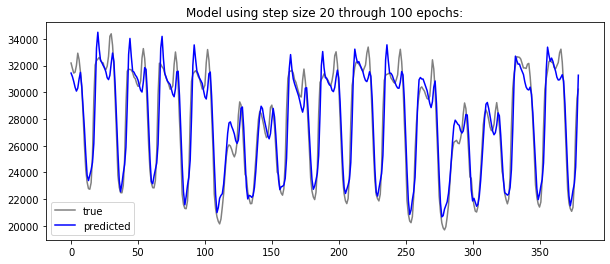

In [197]:
run_multivariate(array(pjme.iloc[0:2000,:]), target=0, n_steps=20, epochs=100)

## Tuning Multivariate LSTM:

Now that we've built a model that we know works, let's improve it. The first thing we can do is scale our data such that it all lies within the same range (in general, this is from 0 to 1). Dealing with data on the same scale allows our neural network to converge more efficiently.

Using the MinMaxScaler tool from sklearn allows us to both scale our data before training, and un-scale it afterwards.

In [15]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
pjme_scaled = scaler.fit_transform(array(pjme))

Now all of the values in the output array are scaled to be between 0 and 1

#### Splitting train, validation, and test data:


We should set some portion of our time series aside to serve as validation data. For this model, we will use 90% of the data to train and the last 10% to test.

In [144]:
#train/test split
cutoff1 = floor(0.8*pjme_scaled.shape[0])
cutoff2 = floor(0.9*pjme_scaled.shape[0])
train = pjme_scaled[0:cutoff1,:]
validation = pjme_scaled[cutoff1:cutoff2,:]
test = pjme_scaled[cutoff2:,:]

#### Creating progress checks:
While our function is running, we want to create snapshots of how our model is performing so that we can detect when we have optomized. Additionally, we want to allow our model to stop prematurely if there are no improvements to the model after a series of epochs. Thiw will save us compute time. Lastly, we allow our training model to reduce the learning rate by a factor of 10 after the first time there is no improvement from one epoch to the next. This will hopefully allow our model to continue improving.

#### Creating checkpoints:

In [20]:
from tensorflow.compat.v2.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(filepath = './Checkpoints/checkpoint.keras',
                            monitor = 'val_loss',
                            verbose = 1,
                            save_weights_only = 1,
                            save_best_only = 1)

#### Allow early stopping:

In [21]:
from tensorflow.compat.v2.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)

#### Log process:

In [25]:
from tensorflow.compat.v2.keras.callbacks import TensorBoard
tensorboard = TensorBoard(log_dir='./Logs/',
                                   histogram_freq=0,
                                   write_graph=False)

#### Reduce learning rate:

In [26]:
from tensorflow.compat.v2.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)

In [27]:
callbacks = [early_stopping,
             checkpoint,
             tensorboard,
             reduce_lr]

#### Training the model:

Now we can move on to training our model. In this model, we choose to use a sigmoid activation function since a relu function tended to create NaN loss values. We again use the adam optomiser and mean squared error, and we use a single layer to improve training speed.

In [192]:
#initialize model

model = Sequential()
model.add(LSTM(32, 
               activation='sigmoid',
               input_shape=(None,pjme_scaled.shape[1])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [193]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 32)                5248      
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 33        
Total params: 5,281
Trainable params: 5,281
Non-trainable params: 0
_________________________________________________________________


In [194]:
step_size = 24*7*2 #two weeks

X,y = get_multiple_inputs(train, 0, step_size)
X_val, y_val = get_multiple_inputs(validation, 0, step_size)

#### Training the model:

In [195]:
%%time
epochs = 20
model.fit(x = X, y = y,
          batch_size = 64,
          epochs = epochs,
          validation_data = (X_val, y_val),
          callbacks = callbacks,
          shuffle = False)

Train on 115956 samples, validate on 14201 samples
Epoch 1/20
115904/115956 [============================>.] - ETA: 0s - loss: 0.0073
Epoch 00001: val_loss did not improve from 0.00163
115956/115956 [==============================] - 604s 5ms/sample - loss: 0.0073 - val_loss: 0.0090
Epoch 2/20
115904/115956 [============================>.] - ETA: 0s - loss: 0.0018
Epoch 00002: val_loss improved from 0.00163 to 0.00090, saving model to ./Checkpoints/checkpoint.keras
115956/115956 [==============================] - 1166s 10ms/sample - loss: 0.0018 - val_loss: 8.9861e-04
Epoch 3/20
115904/115956 [============================>.] - ETA: 0s - loss: 8.1838e-04
Epoch 00003: val_loss improved from 0.00090 to 0.00070, saving model to ./Checkpoints/checkpoint.keras
115956/115956 [==============================] - 548s 5ms/sample - loss: 8.1812e-04 - val_loss: 6.9971e-04
Epoch 4/20
115904/115956 [============================>.] - ETA: 0s - loss: 7.2027e-04
Epoch 00004: val_loss did not improve fro

KeyboardInterrupt: 

In [196]:
try:
    model.load_weights('./Checkpoints/checkpoint.keras')
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

test loss: 0.022847387651391497
RMSE: 1084.4512548732978


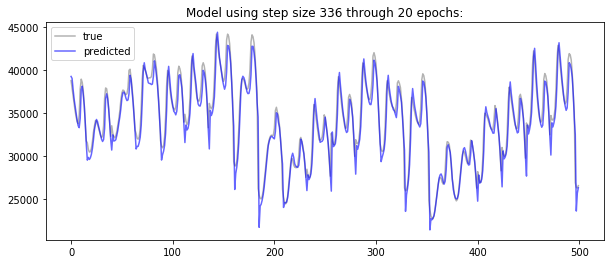

In [197]:
# test model
# get y_predict and y_test to compare
X_test, y_test = get_multiple_inputs(test, 0, 50)
y_predict = model.predict(X_test, verbose=0)

print(f'test loss: {mean_squared_error(y_test, y_predict)**0.5}')

# unscale the data to get true values:
y_len = y_test.shape[0]
y_test = scaler.inverse_transform(np.hstack((y_test.reshape((y_len,1)), np.zeros((y_len,7)))))[:,0]
y_predict = scaler.inverse_transform(np.hstack((y_predict.reshape((y_len,1)), np.zeros((y_len,7)))))[:,0]

# print error
print(f'RMSE: {mean_squared_error(y_test, y_predict)**0.5}')

# plot model
fig, ax = plt.subplots(1,1, figsize = (10,4))
ax.plot(y_test[0:500], color='gray', label='true', alpha = 0.6)
ax.plot(y_predict[0:500], color='blue', label='predicted', alpha = 0.6)
ax.set_title(f'Model using step size {step_size} through {epochs} epochs:')
ax.legend()
plt.show()